In [2]:
import pymc as pm 
import arviz as az 
import pandas as pd 
import numpy as np
import pytensor.tensor as pt
import graphviz

In [3]:
df = pd.read_csv('../data/processed/vax_pop_merged.csv')
df.columns

Index(['fips', 'county_x', 'state_x', 'mmr_coverage', 'year', 'count',
       'had_cases', 'state_fips', 'county_fips', 'state_y', 'county_y',
       'population', 'pop_under5', 'pop_5to13', 'pop_14to17', 'pop_18to24',
       'pop_25to44', 'pop_45to64', 'pop_65plus', 'area_sqkm', 'area_sqmi',
       'pop_density'],
      dtype='object')

Derive IDs and z-scored covariates: 

In [4]:
df['state_id'] = df['state_x'].astype('category').cat.codes
df['year'] = df['year'].astype('category').cat.codes 

age_cols = [c for c in df.columns if c.startswith('pop_')]

def zscore(x): 
    mu, sd = np.nanmean(x), np.nanstd(x)
    if sd == 0 or np.isnan(sd):
        return np.zeros_like(x, dtype=float)
    return (x - mu) / sd

# For pop density, log1p then z-score
df['log_pop_density'] = zscore(np.log1p(df['pop_density']))
for col in age_cols:
    df[f'z_{col}'] = zscore(df[col])

# Final list of covariates
X_cols = ['log_pop_density'] + [f'z_{c}' for c in age_cols]
X_cols

['log_pop_density',
 'z_pop_under5',
 'z_pop_5to13',
 'z_pop_14to17',
 'z_pop_18to24',
 'z_pop_25to44',
 'z_pop_45to64',
 'z_pop_65plus',
 'z_pop_density']

Build model arrays: 

In [5]:
# Core arrays
state_idx = df['state_id'].to_numpy()
year_idx = df['year'].to_numpy()
pop = df['population'].to_numpy(dtype=float)
mmr = df['mmr_coverage'].to_numpy(dtype=float)
y_obs = df['count'].to_numpy(dtype=int)

# Covariate matrix
X = df[X_cols].to_numpy(dtype=float) 

S = df['state_id'].nunique()
T = df['year'].nunique()
N = len(y_obs)
P = X.shape[1]

states = df['state_x'].astype('category').cat.categories.tolist()
years = sorted(df['year'].unique().tolist())

# Epidemiological constants
VE = 0.97           # Vaccine efficacy
gamma = 1.0/7.0     # Recovery rate (1/duration of infectiousness)
eps = 1e-6          # Small constant to avoid log(0)  

len(y_obs), S, T, X.shape

(17337, 39, 8, (17337, 9))

Specify the PyMC model (transmission --> $R_0$ --> $p_c$)

In [6]:
with pm.Model(coords={'obs': np.arange(N), 'state': np.arange(S), 'year': np.arange(T), 'feature': np.arange(P)}) as bhm: 
    state_i = pm.Data("state_i", state_idx, dims="obs")
    year_i  = pm.Data("year_i",  year_idx,  dims="obs")
    X_      = pm.Data("X", X, dims=("obs","feature"))
    pop_    = pm.Data("pop", pop, dims="obs")
    mmr_    = pm.Data("mmr", mmr, dims="obs")

    # Global intercept for baseline log-risk 
    alpha = pm.Normal("alpha", -5.0, 2.0)

    # Hierarchy on baseline transmission (NON-CENTERED) 
    mu_log_beta0 = pm.Normal("mu_log_beta0", mu=0.76, sigma=0.25) # Prior informed by literature
    sd_log_beta0 = pm.HalfNormal("sd_log_beta0", 1.0)
    z_state = pm.Normal("z_state", 0.0, 1.0, dims="state")
    log_beta0_state = pm.Deterministic(
        "log_beta0_state", mu_log_beta0 + z_state * sd_log_beta0, dims="state"
    )

    # Effects of covariates as modifiers on transmission 
    beta_cov = pm.Normal("beta_cov", 0.0, 1.0, dims="feature")

    # Year-level random effect, e.g. policy changes, new variants 
    sd_year = pm.HalfNormal("sd_year", 1.0)
    z_year = pm.Normal("z_year", 0.0, 1.0, dims="year")
    delta_year = pm.Deterministic("delta_year", z_year * sd_year, dims="year")

    # Calculate log-transmission rate for each observation 
    log_beta_total = (log_beta0_state[state_i] + (X_ @ beta_cov) + delta_year[year_i])

    # Calculate R0 for each observation based on unique beta
    R0_obs = pm.Deterministic("R0_obs", pt.exp(log_beta_total) / gamma, dims="obs")

    # Calculate susceptible fraction 
    susceptible_frac = 1.0 - pt.clip(VE * mmr_, 0, 0.999)

    # Calculate Re for each observation 
    Re = pm.Deterministic("Re", R0_obs * susceptible_frac, dims="obs")

    # Linear predictor 
    linpred = alpha + pt.log(Re + eps)
    mu = pt.exp(pt.log(pop_) + linpred)

    # Likelihood
    phi = pm.Gamma("phi", alpha=2.0, beta=0.1)
    y = pm.NegativeBinomial("y", mu=mu, alpha=phi, observed=y_obs, dims="obs")

    # Derived analytical thresholds
    R0_state = pm.Deterministic("R0_state", pt.exp(log_beta0_state) / gamma, dims="state")
    pc_state = pm.Deterministic("pc_state", 1.0 - (1.0 / R0_state), dims="state")

    R0_overall = pm.Deterministic("R0_overall", pt.exp(mu_log_beta0) / gamma)
    pc_overall = pm.Deterministic("pc_overall", 1.0 - (1.0 / R0_overall))

    

In [7]:
gv = pm.model_to_graphviz(bhm)
print(type(gv))
print(gv.source[:800])
png = gv.pipe(format='png')
print("Rendered bytes:", len(png))

<class 'graphviz.dot.Digraph'>
digraph {
	subgraph "clusterobs (17337)" {
		Re [label="Re
~
Deterministic" shape=box]
		R0_obs [label="R0_obs
~
Deterministic" shape=box]
		pop [label="pop
~
Data" shape=box style="rounded, filled"]
		year_i [label="year_i
~
Data" shape=box style="rounded, filled"]
		y [label="y
~
NegBinomial" shape=ellipse style=filled]
		state_i [label="state_i
~
Data" shape=box style="rounded, filled"]
		mmr [label="mmr
~
Data" shape=box style="rounded, filled"]
		label="obs (17337)" labeljust=r labelloc=b style=rounded
	}
	subgraph "clusterobs (17337) x feature (9)" {
		X [label="X
~
Data" shape=box style="rounded, filled"]
		label="obs (17337) x feature (9)" labeljust=r labelloc=b style=rounded
	}
	sd_log_beta0 [label="sd_log_beta0
~
HalfNormal" shape=ellipse]
	pc_overall [label="pc_overall
~
Determi
Rendered bytes: 135226


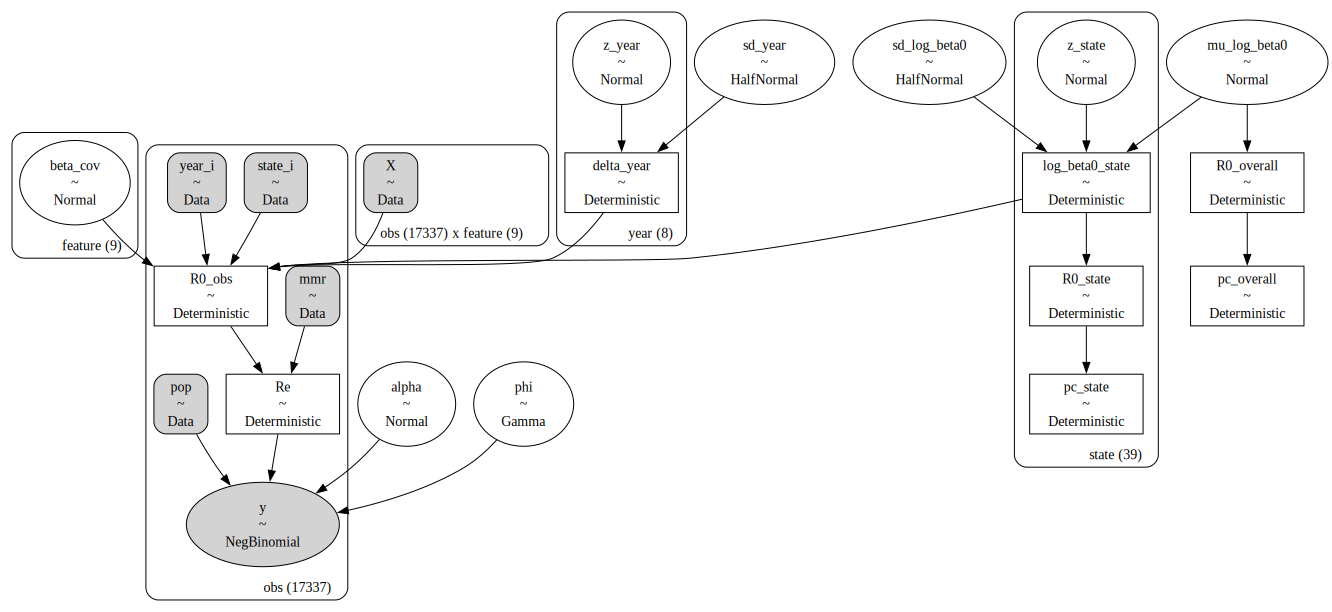

In [8]:
pm.model_to_graphviz(bhm)

In [9]:
print("N observations:", len(y_obs))
print("Covariate matrix shape:", X.shape)
print("states (S):", S, "years (T):", T)
print("Number of model free random variables:", len(bhm.free_RVs))
print("List of free RV names:", [v.name for v in bhm.free_RVs])

N observations: 17337
Covariate matrix shape: (17337, 9)
states (S): 39 years (T): 8
Number of model free random variables: 8
List of free RV names: ['alpha', 'mu_log_beta0', 'sd_log_beta0', 'z_state', 'beta_cov', 'sd_year', 'z_year', 'phi']


Short smoke test: 

In [11]:
with bhm: 
    idata_test = pm.sample(500, tune=500, chains=2, target_accept=0.9, progressbar=True)
var_names = ['alpha', 'mu_log_beta0', 'sd_log_beta0', 'beta_cov', 'sd_year', 'phi']
az.summary(idata_test, var_names=var_names)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu_log_beta0, sd_log_beta0, z_state, beta_cov, sd_year, z_year, phi]


/home/asen/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 120 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-15.697,0.876,-17.146,-14.040,0.046,0.035,383.0,438.0,1.01
mu_log_beta0,0.594,0.254,0.120,1.089,0.005,0.011,2588.0,498.0,1.00
sd_log_beta0,1.183,0.204,0.811,1.556,0.011,0.006,367.0,597.0,1.00
beta_cov[0],0.617,0.146,0.356,0.878,0.004,0.005,1227.0,783.0,1.00
beta_cov[1],-0.051,0.289,-0.564,0.509,0.009,0.008,980.0,828.0,1.00
beta_cov[2],0.022,0.503,-0.918,0.944,0.016,0.019,1019.0,670.0,1.00
beta_cov[3],0.275,0.332,-0.376,0.871,0.010,0.011,1226.0,874.0,1.00
beta_cov[4],-0.211,0.474,-1.088,0.685,0.020,0.014,544.0,678.0,1.00
beta_cov[5],0.046,0.447,-0.775,0.878,0.018,0.013,592.0,683.0,1.00
beta_cov[6],-0.429,0.416,-1.238,0.306,0.017,0.013,634.0,659.0,1.00


Real sampling run: 

In [12]:
with bhm:
    idata = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        target_accept=0.95,
        progressbar=True,
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, mu_log_beta0, sd_log_beta0, z_state, beta_cov, sd_year, z_year, phi]


/home/asen/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 524 seconds.


In [13]:
az.summary(idata, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-15.627,0.903,-17.330,-13.990,0.023,0.016,1529.0,2908.0,1.0
mu_log_beta0,0.597,0.250,0.135,1.061,0.002,0.003,12623.0,6253.0,1.0
sd_log_beta0,1.190,0.207,0.821,1.580,0.004,0.002,2532.0,4492.0,1.0
beta_cov[0],0.611,0.142,0.357,0.890,0.002,0.001,6895.0,6137.0,1.0
beta_cov[1],-0.051,0.297,-0.627,0.482,0.004,0.003,4434.0,5846.0,1.0
beta_cov[2],0.023,0.477,-0.846,0.938,0.007,0.005,4869.0,5492.0,1.0
beta_cov[3],0.273,0.331,-0.325,0.892,0.004,0.003,5615.0,6371.0,1.0
beta_cov[4],-0.211,0.456,-1.065,0.665,0.009,0.005,2372.0,3784.0,1.0
beta_cov[5],0.047,0.441,-0.772,0.893,0.009,0.005,2485.0,3614.0,1.0
beta_cov[6],-0.429,0.402,-1.154,0.354,0.008,0.004,2598.0,4142.0,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'mu_log_beta0'}>,
        <Axes: title={'center': 'mu_log_beta0'}>],
       [<Axes: title={'center': 'sd_log_beta0'}>,
        <Axes: title={'center': 'sd_log_beta0'}>],
       [<Axes: title={'center': 'beta_cov'}>,
        <Axes: title={'center': 'beta_cov'}>],
       [<Axes: title={'center': 'sd_year'}>,
        <Axes: title={'center': 'sd_year'}>],
       [<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>]],
      dtype=object)

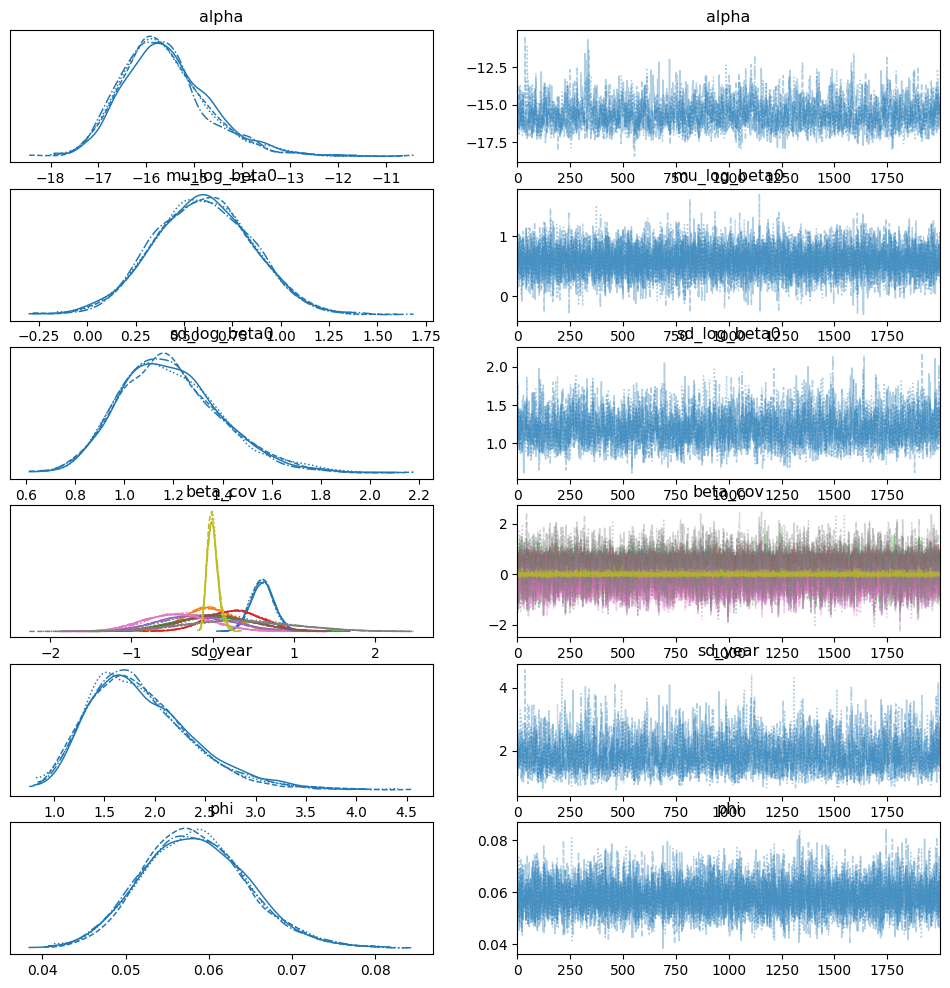

In [14]:
az.plot_trace(idata, var_names=var_names)

In [15]:
# Extract the posterior distribution for the overall p_c
post = az.extract(idata)
pc_analytical = post['pc_overall'].to_numpy()

# Get the median and 94% credible interval
print(np.quantile(pc_analytical, [0.03, 0.50, 0.97]))

p_c_analyt = np.median(pc_analytical)
print("Overall critical vaccination threshold (analytical):", p_c_analyt)

[0.87527726 0.92139376 0.95057165]
Overall critical vaccination threshold (analytical): 0.9213937581512006
